# Forecasting Hurricane Tracks using Satellite Data Accessed from AWS

When I originally took a crack at forecasting hurricanes with Tensorflow back in 2019, I used Reanalysis data I had to download via ftp and satelitte imagery I webscraped from NASA. It worked well enough, except the reanlysis II data had one major flaw; it was not a perfect mirror for what could be acquired live via NOAA's various other products. Since that time, there's been a major effort by NOAA and other government agencies via the [NOAA Big Data Program](https://www.noaa.gov/organization/information-technology/big-data-program) to move many of both NOAA and NASA's data products to the cloud, both on Amazon AWS and Google Cloud. Many of these datasets span back 3-4 years, and include hourly observations, instead of the 6 hour increments from the reanalysis datasets previously used. Most importantly, however, new observations are added live, in the same format and in the same location, so using a model developed with these datasets could be adapted to live forecasting with minimal effort.

The downside here is that the historic data would ideally cover a longer time period. Our historic track data is every 3 hours, so even if we augment this via interpolation and assume that our hourly interpolated data is accurate enough to use for training, we're still limited in that there were a finite number of storms during this period and there may be several regions of the world that commonly see storms pass through which didn't see one during this period, and therefore our model may not properly learn storm behavoirs in those redions.

Ultimately, down the road we'll probably  want to create a composite training set that includes the previous Reanlysis II data as well, but I wanted to first present a comprehensive methodology for accessing these new datasets, and using them to train Tensorflow models. Adding in the older data for a longer training period is likely to be the next step, and will likely require that we shift which AWS / GCP datasets we draw from to match like with like, but the code to access them should work the same. 

To begin, I'll start with the Geospatial Satellite data from AWS (GEOS16 and 17). The Google data requires a few extra steps to use properly as you need to sign up for a Google Earth Engine account. Google Earth Engine offers a lot of nice features, from the ability to export data into tf.data datasets to being able to use it to directly train hosted models directly on GCP and create high resolution maps including data from other sources fairly easily, but the drawback is that most of the examples are in javascript and assume users will use the javascript browser IDE to pull data. That means some going back and forth from python to js. So, I'm going to start with the AWS data for now, as it allows me to keep everything in a single Jupyter notebook that doesn't rely on premium GCP services to run and is fairly easy follow.

Anyway, Let's begin!

As a starting point, check out this notebook: [Visualize GOES-16 Data from S3](https://github.com/HamedAlemo/visualize-goes16/blob/master/visualize_GOES16_from_AWS.ipynb)

I'll be using some of the code here to get things rolling.

In [27]:
import xarray as xr
import requests
import netCDF4
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime,timedelta
from tqdm import tqdm
import gc
import os
from IPython.display import Image
import cv2
os.environ['PROJ_LIB'] = r'c:\Users\kylea\AppData\Local\conda\conda\envs\hurricanes\Library\share'

from mpl_toolkits.basemap import Basemap
from pyproj import Proj
import numpy as np

# Initial Dataset
The dataset I'll be using to start is the GEOS16 ABI-L1b-RadF - Advanced Baseline Imager Level 1b (Full Disk). According to [their website](https://www.noaa.gov/organization/information-technology/big-data-program) the Level 1b data is for 16 visible, near-infrared, and infrared spectral bands from .5km to 2km spatial resolution. This code retrieves the file from the S3 bucket associated with the 12th band channel for a given timestamp, which we will later use to along with the second dataset (3-hourly position data for historic storms). GOES makes 4 measurements in each hour for each band. 

The reason for picking this dataset is simple... it covers the longest time period of what's on AWS. In an idea world, we'd want to pull in several of these 'buckets'... most obviously the sea surface temperature, ground temperature, cloud top temperature and derived motion winds. But we only have a couple years for those sets. Once we integrate this with historic reanalysis data for augmented training, we will likely want to bring those into our model, however.

Also, there are 16 bands to choose from within this bucket. Visible and near visible are less than ideal as we see a black disk at night, but there are several bands that show very clear images all night, especially the higher ones, which provide similar views both at night as well as during the day. Ideally, we'd experiment with all possibly combination of these bands to find the ideal mix. For this initial notebook, however, we'll go with band 16, which shows us a 13.27 um wavelength.

Note: L2 derived products are also available for the same timespan. We could use reflectance instead of raw radiance by switching to the L2 dataset, but from some experimentation, I found that the centered hurricane images offered less detail using this approach. It may be worth experimenting with that dataset again as well, but for a first attempt, raw radiance will be used. For more on reflectance vs. radiance, see [here](https://www.l3harrisgeospatial.com/Support/Self-Help-Tools/Help-Articles/Help-Articles-Detail/ArtMID/10220/ArticleID/19247/3377#:~:text=Radiance%20is%20the%20variable%20directly,from%20the%20object%20being%20observed.&text=Reflectance%20is%20the%20ratio%20of,It%20has%20no%20units.).

Additional information regarding the GEOS16 Satellite can be found [here](https://www.goes-r.gov/products/docs/PUG-L2+-vol5.pdf).

In [2]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L1b-RadF'#'ABI-L2-DMWF'#'ABI-L2-CMIPF'#'ABI-L1b-RadF'#ABI-L2-ACHTF#'ABI-L2-ACTPF'#
year = 2017
day_of_year = 60
hour = 0
band = 14

In [3]:
# Initialize s3 client. 
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [4]:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [5]:
print(f'{day_of_year:02.0f}')

60


In [6]:
keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M3C{band:02.0f}'
                  )
# keys = get_s3_keys(bucket_name,
#                    s3_client)
#                    prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M3C{band:02.0f}'
#                   )
all_keys= [key for key in keys]
key = all_keys[0] # selecting the first measurement taken within the hour

In [7]:
resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key}')

In [8]:
%%time
file_name = key.split('/')[-1].split('.')[0]
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)

Wall time: 8 ms


Wall time: 626 ms


(-0.5, 5423.5, 5423.5, -0.5)

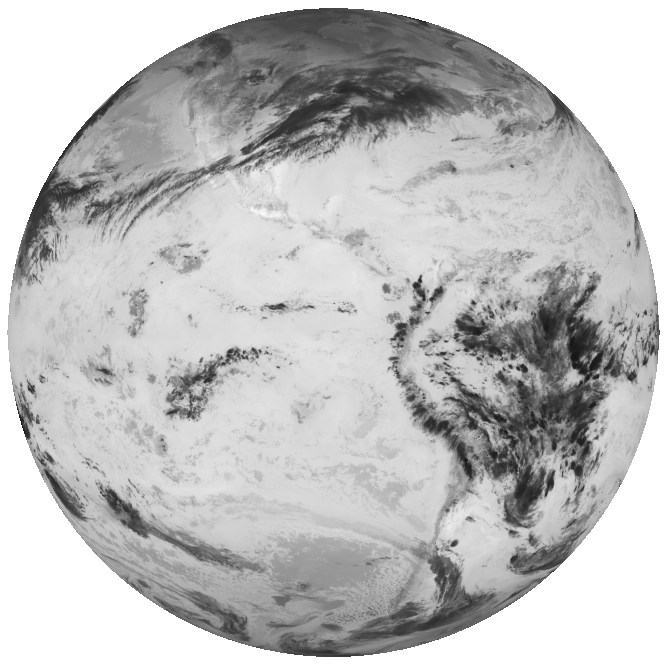

In [10]:
%%time
fig = plt.figure(figsize=(12, 12))
rad=nc4_ds.variables['Rad'][:]
plt.imshow(rad, cmap='gray')
plt.axis('off')
# plt.savefig(f'{file_name}.png', dpi=300, facecolor='w', edgecolor='w',bbox_inches='tight',pad_inches=0,transparent=True)

In [11]:
nc4_ds.variables

{'Rad': <class 'netCDF4._netCDF4.Variable'>
 int16 Rad(y, x)
     _FillValue: 4095
     long_name: ABI L1b Radiances
     standard_name: toa_outgoing_radiance_per_unit_wavenumber
     _Unsigned: true
     sensor_band_bit_depth: 12
     valid_range: [   0 4094]
     scale_factor: 0.049492206
     add_offset: -1.7187
     units: mW m-2 sr-1 (cm-1)-1
     resolution: y: 0.000056 rad x: 0.000056 rad
     coordinates: band_id band_wavelength t y x
     grid_mapping: goes_imager_projection
     cell_methods: t: point area: point
     ancillary_variables: DQF
 unlimited dimensions: 
 current shape = (5424, 5424)
 filling on,
 'DQF': <class 'netCDF4._netCDF4.Variable'>
 int8 DQF(y, x)
     _FillValue: -1
     long_name: ABI L1b Radiances data quality flags
     standard_name: status_flag
     _Unsigned: true
     valid_range: [0 3]
     units: 1
     coordinates: band_id band_wavelength t y x
     grid_mapping: goes_imager_projection
     cell_methods: t: point area: point
     flag_values: [0

In [12]:

# Height of the satellite's orbit
height = nc4_ds.variables['goes_imager_projection'].perspective_point_height

# Longitude of the satellite's orbit
lon = nc4_ds.variables['goes_imager_projection'].longitude_of_projection_origin
lat = nc4_ds.variables['goes_imager_projection'].latitude_of_projection_origin

# Which direction do we sweep in?
sweep = nc4_ds.variables['goes_imager_projection'].sweep_angle_axis

X = nc4_ds.variables['x'][:] * height
Y = nc4_ds.variables['y'][:] * height

# g16nc.close()
# g16nc = None

# Zoom
https://stackoverflow.com/questions/14748226/orthographic-projection-python

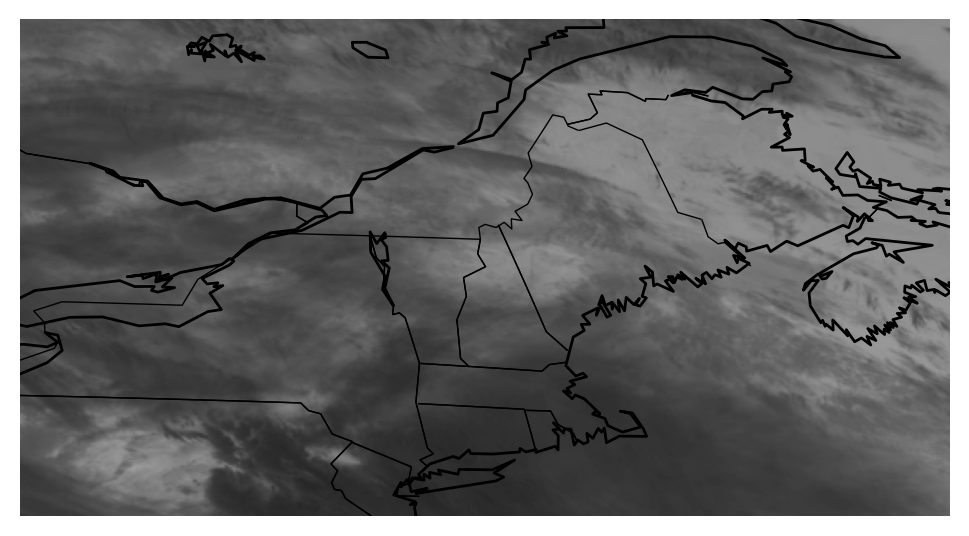

In [13]:
fig = plt.figure(figsize=(6,6),dpi=200)
m = Basemap(resolution='l', projection='geos', lon_0=lon,lat_0=lat,rsphere=(6378137.00,6356752.3142))
#             llcrnrx=X.min(), llcrnry=Y.min(), urcrnrx=X.max(), urcrnry=Y.max())
m.imshow(np.flipud(rad),cmap='gray')
m.drawcountries()
m.drawcoastlines()
m.drawstates()

lllon = -80.
urlon = -60.
lllat = 40.
urlat = 50.

xmin, ymin = m(lllon, lllat)
xmax, ymax = m(urlon, urlat)

ax = plt.gca()

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

# Tinker with the Formatting
This is cool and all, but I doubt hurricanes care about political boundaries. I could, however, see terrain being a useful feature. Luckily, there's a nice background we can use called "bluemarble" which gives us the clearsky daytime view of the globe, which we should be able to use as a backdrop behind our satellite image data. Remember, we're using sensor data here from outside the visible spectrum, but what we see with is is essentially still the same cloud features, so we should essentially be able to create rough simulations of a daytime view of the hurricane, but during all hours this way. What's more, we can make the clouds semi-transparent, so our AI algorithm will be able to "see" them, while also being able to "see" the terrain features below. So, this will be like looking at the earth with X-ray full color night vision.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


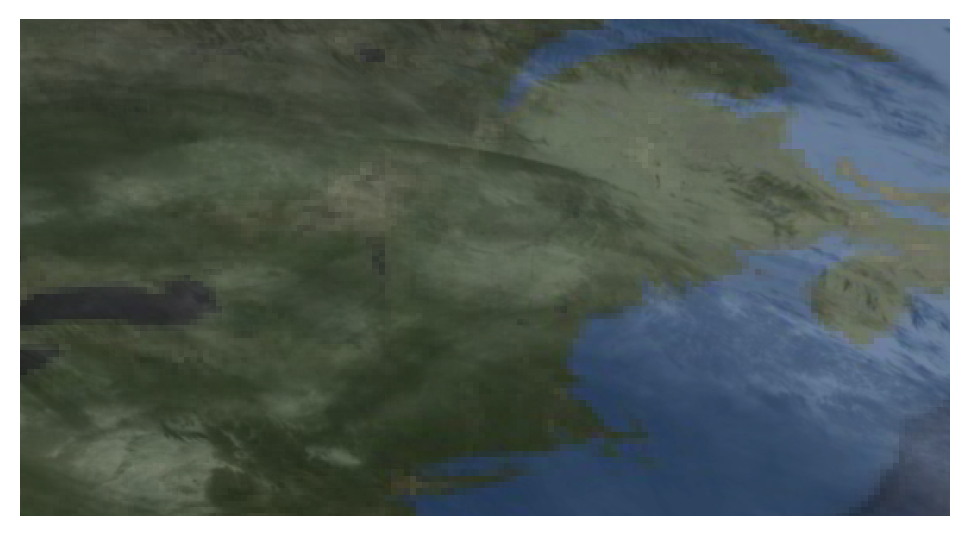

In [14]:
fig = plt.figure(figsize=(6,6),dpi=200)
m = Basemap(resolution='l', projection='geos', lon_0=lon,lat_0=lat,rsphere=(6378137.00,6356752.3142))
#             llcrnrx=X.min(), llcrnry=Y.min(), urcrnrx=X.max(), urcrnry=Y.max())
m.bluemarble()
m.imshow(np.flipud(rad).astype('uint8'),cmap='gray',vmin=0,vmax=100,alpha=0.5); #make it black / white

lllon = -80.
urlon = -60.
lllat = 40.
urlat = 50.

xmin, ymin = m(lllon, lllat)
xmax, ymax = m(urlon, urlat)

ax = plt.gca()

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

# Make this into a function
We'll want square images ideally, centered around where the storm currently is located. So let's get some scaling factors calculated and make a version of the above that returns an image that we can either save or show. Then, we can interate through our track data and generate centered images for each track position, as well as generate a single full view shot for that timestamp that all active storms during that time will share.

In [15]:
num_lons,num_lats=len(X),len(Y)
min_lon=nc4_ds.variables['geospatial_lat_lon_extent'].geospatial_westbound_longitude
max_lon=nc4_ds.variables['geospatial_lat_lon_extent'].geospatial_eastbound_longitude
min_lat=nc4_ds.variables['geospatial_lat_lon_extent'].geospatial_southbound_latitude
max_lat=nc4_ds.variables['geospatial_lat_lon_extent'].geospatial_northbound_latitude
lat_range=max_lat-min_lat
lon_range=max_lon-min_lon
#range ends up being the same...

In [16]:
def gen_image(m,year=2017,day_of_year=60,hour=0,band=12,margin=10,center_lat=45,center_lon=-70,SID='',my_dpi=200,save_img=True,show_lines=True):
    gc.collect()
    keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M3C{band:02.0f}'
                  )
    key=next(keys)#just get first key, for first image after the hour.
    resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key}')
    
    file_name = key.split('/')[-1].split('.')[0]
    g16nc = netCDF4.Dataset(file_name, memory = resp.content)
    

    height = g16nc.variables['goes_imager_projection'].perspective_point_height

    # Longitude of the satellite's orbit
#     lon = g16nc.variables['goes_imager_projection'].longitude_of_projection_origin
#     lat = g16nc.variables['goes_imager_projection'].latitude_of_projection_origin

    # Which direction do we sweep in?
#     sweep = g16nc.variables['goes_imager_projection'].sweep_angle_axis

    X = g16nc.variables['x'][:] * height
    Y = g16nc.variables['y'][:] * height
    rad=g16nc.variables['Rad'][:]
    
    fig=plt.figure(figsize=(300/my_dpi, 300/my_dpi), dpi=my_dpi);
#     fig = plt.figure(figsize=(6,6),dpi=200)
#     m = Basemap(resolution='l', projection='geos', lon_0=lon,lat_0=lat,rsphere=(6378137.00,6356752.3142));
    #             llcrnrx=X.min(), llcrnry=Y.min(), urcrnrx=X.max(), urcrnry=Y.max())
#     m.fillcontinents(color='coral',lake_color='aqua')

    if show_lines:
#         m.drawlsmask()
        m.bluemarble();
#         m.drawcountries()
#         m.drawcoastlines()
#         m.drawstates()
    im=m.imshow(np.flipud(rad).astype('uint8'),cmap='gray',vmin=0,vmax=100,alpha=0.5); #make it black / white

    lllon = center_lon-margin
    urlon = center_lon+margin
    lllat = center_lat-margin
    urlat = center_lat+margin

    xmin, ymin = m(lllon, lllat)
    xmax, ymax = m(urlon, urlat)
    xrange=xmax-xmin
    yrange=ymax-ymin
    xcenter=(xmin+xmax)/2
    ycenter=(ymin+ymax)/2
    usable_range=min(xrange,yrange)
    xmin=xcenter-usable_range/2
    xmax=xcenter+usable_range/2
    ymin=ycenter-usable_range/2
    ymax=ycenter+usable_range/2
    ax = plt.gca();

    ax.set_xlim([xmin, xmax]);
    ax.set_ylim([ymin, ymax]);
    if save_img:
        plt.axis('off');
        centered_filename=rf"./storm_centered/centered_{SID}_{year}{day_of_year}{hour}.png"
        plt.savefig(centered_filename, bbox_inches='tight',pad_inches=0,transparent=True);
    plt.close(fig) #memory leak if you don't close fig
    return im

In [19]:
%%time
m = Basemap(resolution='l', projection='geos', lon_0=lon,lat_0=lat,rsphere=(6378137.00,6356752.3142));

Wall time: 1.31 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Wall time: 6.33 s


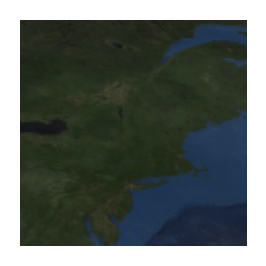

In [63]:
%%time
im=gen_image(m,save_img=False);

When we generate these for real, we'll likely want to take off these political boundaries.

# Historic Track Data
The NHC offers best track data, but only for named storms near the U.S., and positions are only every 6 hours. This may be where we'll have to tie into later on to pull latest known position of active storms to make live forecasts, but for training data, I prefer this resource:

https://www.ncdc.noaa.gov/ibtracs/index.php?name=ib-v4-access
1.  Knapp, K. R., M. C. Kruk, D. H. Levinson, H. J. Diamond, and C. J. Neumann, 2010:
The International Best Track Archive for Climate Stewardship (IBTrACS): Unifying tropical cyclone best track data.
Bulletin of the American Meteorological Society, 91, 363-376.
non-gonvernment domain doi:10.1175/2009BAMS2755.1
1.  Knapp, K. R., H. J. Diamond, J. P. Kossin, M. C. Kruk, C. J. Schreck, 2018:
International Best Track Archive for Climate Stewardship (IBTrACS) Project, Version 4. [indicate subset used]. NOAA National Centers for Environmental Information. non-gonvernment domain https://doi.org/10.25921/82ty-9e16 [access date].


Note: the full historic csv file from the above site is >100MB, the GitHub limit. The version on github is filtered to only include records from Jan 1, 2017 onward, and the majority of the unused columns were removed. If you download the full historic track data, rename it to "clean_tracks.csv" and it should still work with the following code, but let me know if there are any issues.

In [69]:
track_data=pd.read_csv('clean_tracks.csv',usecols=['SID','ISO_TIME','LAT','LON','STORM_SPEED','STORM_DIR'],infer_datetime_format=True)
track_data=track_data.replace(' ',np.nan) #a few hunderd blank rows get brought in at the end.
track_data.dropna(inplace=True)
track_data['SID']=track_data['SID'].astype('string')
track_data['ISO_TIME']=pd.to_datetime(track_data['ISO_TIME'])
track_data['LAT']=track_data['LAT'].astype('float16')
track_data['LON']=track_data['LON'].astype('float16')
track_data['STORM_SPEED']=track_data['STORM_SPEED'].astype('int8')
track_data['STORM_DIR']=track_data['STORM_DIR'].astype('int8')
track_data['STORM_DIR']=np.sin(np.deg2rad(track_data['STORM_DIR']))

In [70]:
track_data.dtypes

SID                    string
ISO_TIME       datetime64[ns]
LAT                   float16
LON                   float16
STORM_SPEED              int8
STORM_DIR             float16
dtype: object

In [71]:
track_data['year']=track_data['ISO_TIME'].dt.year
track_data['day_of_year']=track_data['ISO_TIME'].dt.day_of_year
track_data['hour']=track_data['ISO_TIME'].dt.hour

# Filter by Available GOES Data
Currently oldest datetime

In [72]:
oldest_available=datetime(year=2017,month=1,day=1)+timedelta(days=60)

track_data=track_data[track_data['ISO_TIME']>oldest_available]

In [73]:
track_data.head(-5)

SID            ISO_TIME        LAT        LON  STORM_SPEED  \
407    2017060S09139 2017-03-02 03:00:00  -7.976562  135.12500            8   
408    2017061S11063 2017-03-02 03:00:00 -11.203125   62.09375           16   
409    2017060S09139 2017-03-02 06:00:00  -7.898438  134.75000            6   
410    2017061S11063 2017-03-02 06:00:00 -11.398438   61.18750           16   
411    2017060S09139 2017-03-02 09:00:00  -7.843750  134.50000            6   
...              ...                 ...        ...        ...          ...   
23396  2021036S13081 2021-02-15 18:00:00 -18.906250   69.81250           17   
23397  2021036S13081 2021-02-15 21:00:00 -18.609375   69.00000           15   
23398  2021036S13081 2021-02-16 00:00:00 -18.406250   68.31250           14   
23399  2021048N07133 2021-02-17 06:00:00   6.601562  133.12500            9   
23400  2021048N07133 2021-02-17 09:00:00   6.710938  132.62500            7   

       STORM_DIR  year  day_of_year  hour  
407     0.469482  2017           61     3  
408     0.000000  2017           61     3  
409     0.438477  2017           61     6  
410     0.017456  2017           61     6  
411     0.406738  2017           61     9  
...          ...   ...          ...   ...  
23396   0.629395  2021           46    18  
23397   0.544922  2021           46    21  
23398   0.515137  2021           47     0  
23399   0.469482  2021           48     6  
23400   0.499756  2021           48     9  

[22994 rows x 9 columns]

In [38]:
margin=10
track_data=track_data[track_data['LAT']>min_lat+margin]
track_data=track_data[track_data['LAT']<max_lat-margin]
track_data=track_data[track_data['LON']>min_lon+margin]
track_data=track_data[track_data['LON']<max_lon-margin]


In [39]:
track_data.head()

SID            ISO_TIME       LAT       LON  STORM_SPEED  \
673209  2017106N36310 2017-04-16 06:00:00  35.81250 -50.31250           10   
673210  2017106N36310 2017-04-16 09:00:00  35.43750 -49.90625           10   
673211  2017106N36310 2017-04-16 12:00:00  35.09375 -49.50000           10   
673212  2017106N36310 2017-04-16 15:00:00  34.75000 -49.09375           10   
673213  2017106N36310 2017-04-16 18:00:00  34.40625 -48.68750           10   

        STORM_DIR  year  day_of_year  hour  
673209  -0.875000  2017          106     6  
673210  -0.875000  2017          106     9  
673211  -0.875000  2017          106    12  
673212  -0.875000  2017          106    15  
673213  -0.857422  2017          106    18

In [40]:
track_data.reset_index(inplace=True,drop=True)

In [68]:
track_data.to_pickle('track_data.pkl')

# Sample Storm

In [49]:
row=track_data.iloc[90]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Wall time: 2.06 s


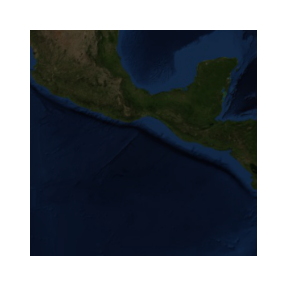

In [50]:
%%time
gen_image(m,year=row['year'],day_of_year=row['day_of_year'],band=8,margin=margin,hour=row['hour'],center_lat=row['LAT'],center_lon=row['LON'],SID=row['SID'],my_dpi=300,save_img=False,show_lines=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


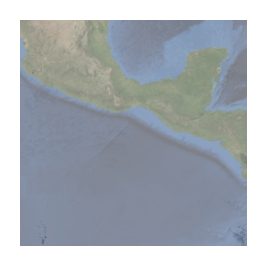

In [51]:
gen_image(m,year=row['year'],day_of_year=row['day_of_year'],band=16,margin=margin,hour=row['hour'],center_lat=row['LAT'],SID=row['SID'],center_lon=row['LON'],my_dpi=200,save_img=False,show_lines=True)


# Crank Out Some Sample Images
Only do 20 for now to see what the timing is. We'll likely want to roll this into a py file and use multiprocessing for the sake of expediency. 

In [ ]:
%%time
errors=[]
for i,row in track_data.iterrows():
#     if i>20:
#         break
    print(i)
    try:
        gen_image(m,year=row['year'],day_of_year=row['day_of_year'],band=16,margin=margin,hour=row['hour'],center_lat=row['LAT'],center_lon=row['LON'],SID=row['SID'],my_dpi=300,save_img=True,show_lines=True)
    except:
        print("error: ",row)
#         errors.append(row)
    gc.collect()
error_df=pd.concat(errors,a  xis=1)
error_df.to_pickle('image_gen_errors.pkl')

0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13
error:  SID                  2017106N36310
ISO_TIME       2017-04-17 21:00:00
LAT                        32.1875
LON                      -44.96875
STORM_SPEED                      5
STORM_DIR                 0.933594
year                          2017
day_of_year                    107
hour                            21
Name: 13, dtype: object
14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21


<ipython-input-21-c706e7063cca>:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(300/my_dpi, 300/my_dpi), dpi=my_dpi);
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42
error:  SID                  2017106N36310
ISO_TIME       2017-04-21 12:00:00
LAT                       39.90625
LON                       -49.3125
STORM_SPEED                     19
STORM_DIR                -0.173706
year                          2017
day_of_year                    111
hour                            12
Name: 42, dtype: object
43
error:  SID                  2017106N36310
ISO_TIME       2017-04-21 15:00:00
LAT                       39.34375
LON                         -50.25
STORM_SPEED                     18
STORM_DIR                -0.587891
year                          2017
day_of_year                    111
hour                            15
Name: 43, dtype: object
44
error:  SID                  2017106N36310
ISO_TIME       2017-04-21 18:00:00
LAT                           38.5
LON                       -50.8125
STORM_SPEED                     21
STORM_DIR                -0.819336
year                          2017
day_of_year                    111
hour     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


54


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


55


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


56


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


57


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


58


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


59


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


61


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


62


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


63


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


66


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


68


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


69


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


71


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


72


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


73


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


74


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


75


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


76


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


77


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


78


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


79


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


81


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


82


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


83


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


84


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


86


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


87


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


88


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


89


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


91


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


92


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


93


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


94


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


95


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


96


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


97


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


98


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


99


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


100
error:  SID                  2017163N14265
ISO_TIME       2017-06-12 21:00:00
LAT                      15.742188
LON                       -95.5625
STORM_SPEED                      4
STORM_DIR                 0.865723
year                          2017
day_of_year                    163
hour                            21
Name: 100, dtype: object
101
error:  SID                  2017163N14265
ISO_TIME       2017-06-13 00:00:00
LAT                      15.898438
LON                       -95.6875
STORM_SPEED                      5
STORM_DIR                 0.829102
year                          2017
day_of_year                    164
hour                             0
Name: 101, dtype: object
102
error:  SID                  2017163N14265
ISO_TIME       2017-06-13 03:00:00
LAT                      16.046875
LON                        -95.875
STORM_SPEED                      5
STORM_DIR                 0.788086
year                          2017
day_of_year                    164
hour

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


106


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


108


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


110


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


112


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


114


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


115


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


as noted above, this is farily slow, so I pulled the appropriate code out and put it into a dedicated py file (centered_storms.py) to run separate. It should work here, though it will take several hours to complete.

# Check Out the Errors

In [20]:
import cv2

In [66]:
error_df=pd.read_pickle('image_gen_errors.pkl')
error_df.head()

SID            ISO_TIME       LAT       LON STORM_SPEED  \
13  2017106N36310 2017-04-17 21:00:00   32.1875 -44.96875           5   
42  2017106N36310 2017-04-21 12:00:00  39.90625  -49.3125          19   
43  2017106N36310 2017-04-21 15:00:00  39.34375    -50.25          18   
44  2017106N36310 2017-04-21 18:00:00      38.5  -50.8125          21   
45  2017106N36310 2017-04-21 21:00:00  37.40625 -51.21875          22   

   STORM_DIR  year day_of_year hour  
13  0.933594  2017         107   21  
42 -0.173706  2017         111   12  
43 -0.587891  2017         111   15  
44 -0.819336  2017         111   18  
45 -0.927246  2017         111   21

In [25]:
print(len(errors))

4891


Unfortunately, there were a lot of errors processing the storm data. My suspicion is that this is because these were near the edges of the disk. A wider margin might be needed in our filter used earlier. From a manual scan of the generated images, several images also appear to have issues, such as a lot of pixelation, as well as clearly showing the edge of the disk (i.e. the horizon), which shouldn't happen with a projection. Here are a couple examples.

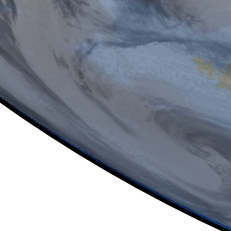

In [29]:
Image(r"./storm_centered/centered_2018300N25315_201830618.png")

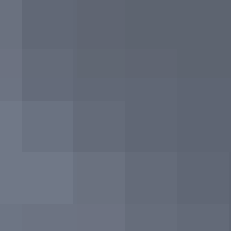

In [30]:
Image(r"./storm_centered/centered_2018300N25315_20183056.png")

In [32]:
problem_storms=errors['SID'].drop_duplicates()
len(problem_storms)

112

In [41]:
len(track_data['SID'].drop_duplicates())

172

This storm (SID 2018300N25315), did have several errors associated with snapshots in the log, though those images never appear to have generated. Should we remove all these storms, including images that generated successfully, or might there be some usable images in there? Let's look at some samples.

In [67]:
def get_image_from_row(row,COLOR_BGR2RGB=False):
    path=rf"./storm_centered/centered_{row['SID']}_{row['year']}{row['day_of_year']}{row['hour']}.png"
    image = cv2.imread(path)  
    if cv2.COLOR_BGR2RGB:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
potential_problem_images=track_data[(track_data['SID'].isin(error_df['SID']) & ()]

In [65]:
fig = plt.figure(figsize=(25, 25))
for i, (idx, row) in enumerate(error_df.sample(100, random_state=2021).iterrows()):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    image=get_image_from_row(row)
    plt.imshow(image)

NameError: name 'error_df' is not defined

<Figure size 1800x1800 with 0 Axes>

To play it safe, I will filter out the problematic storms. This is only going to leave us with 60 of 172 storms, reinforcing the need for additional training data. For this proof of concept model, hopefully this will still be sufficient, but augmenting this additional data seems to be increasingly necessary. One thing we could probably do is to pull in GEOS17 data since many of these problematic storms appear over the Pacific, which GEOS17 has a better view of. We also interpolate the track data to include more timesteps since we have 15 minute satellite data. But ultimately, we will likely want to pair this approach with additional reanalysis 2 data so we can include more storms with a wider diversity of historic tracks.

We only have 3104 images (of 4518 generated) if we do this, which seems to be culling more images than needed (my random manual checking only leads me to think about 10% will be problematic). There are also hundreds in here that are near the edge of the disk, but where a storm is clearly visible. Here's an example.

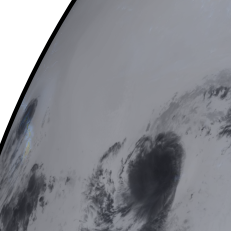

In [43]:
Image(r"./storm_centered/centered_2018244N14252_201825218.png")

I think some additional data engineering / tweeking of the boundary box around the centered storm, the margins for which ones we generate images for can yield us a lot more usable data here. But for now, let's continue with these 3104 images.

# Resulting Image Data

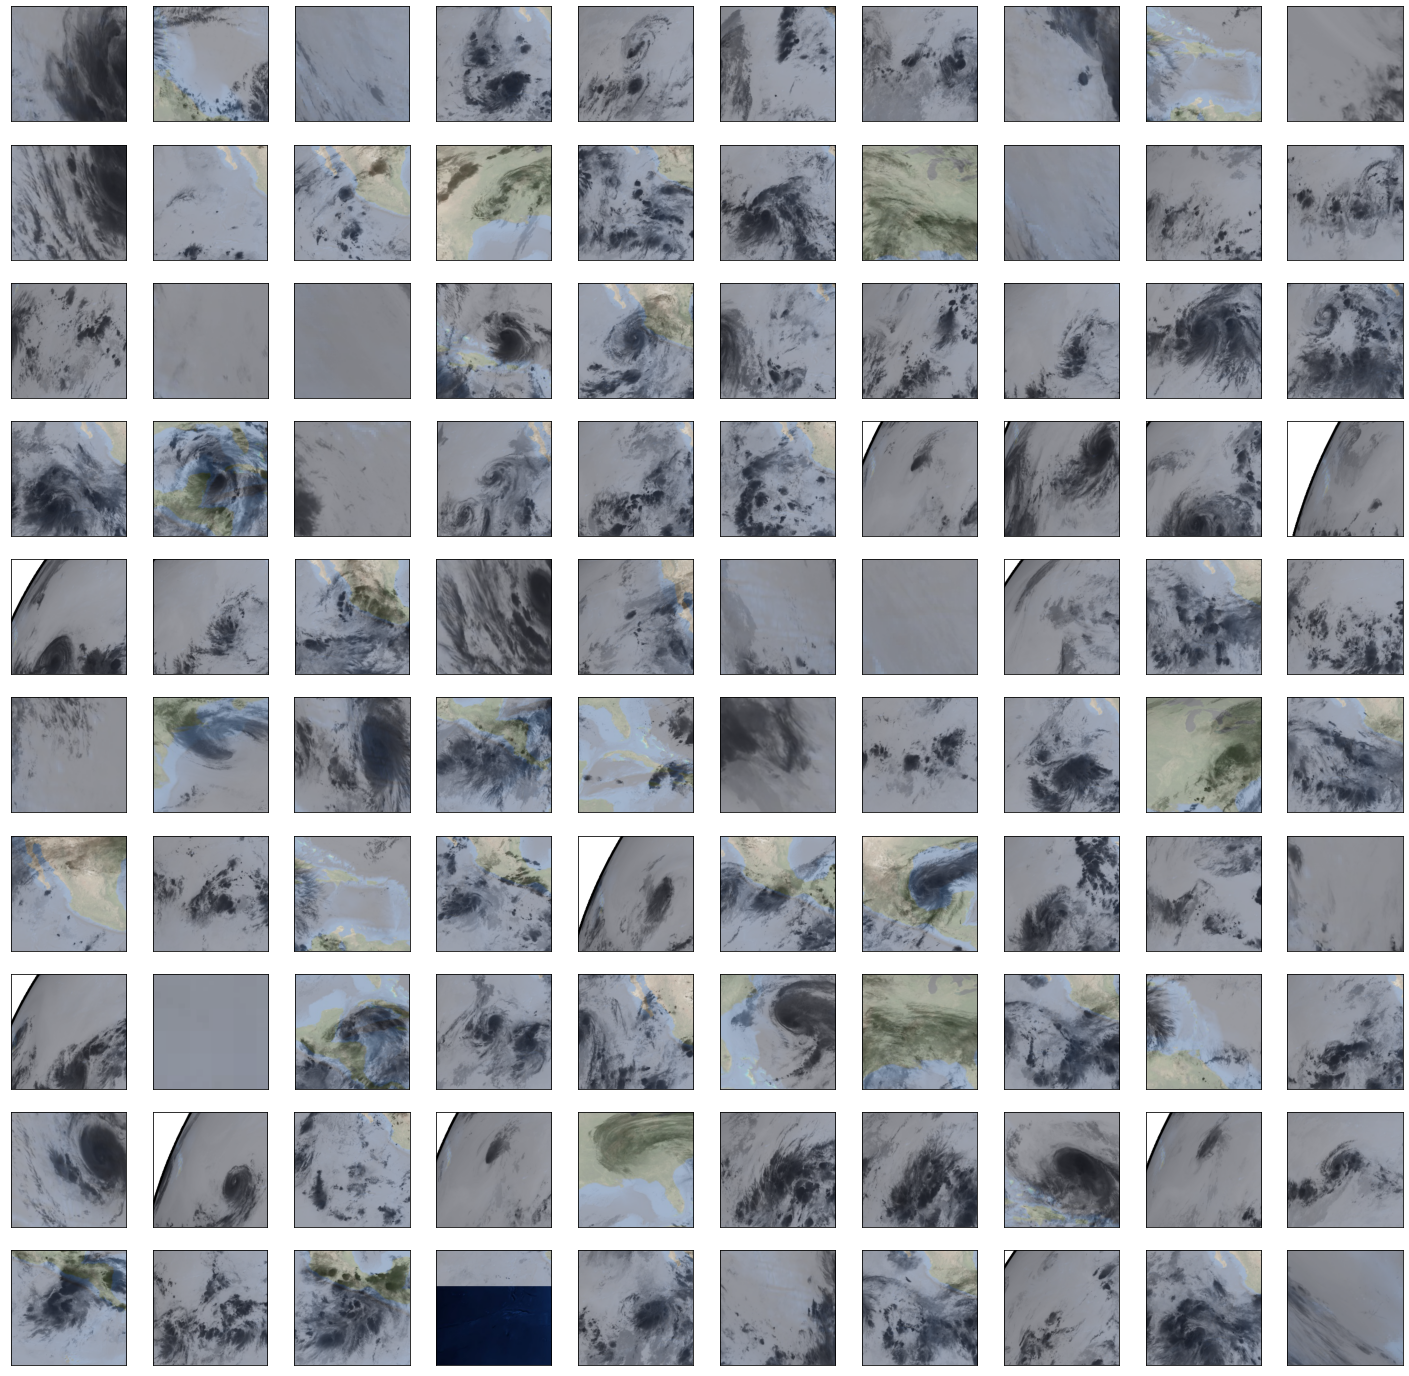

In [62]:
def get_image_from_row(row,COLOR_BGR2RGB=False):
    path=rf"./storm_centered/centered_{row['SID']}_{row['year']}{row['day_of_year']}{row['hour']}.png"
    image = cv2.imread(path)  
    if cv2.COLOR_BGR2RGB:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

fig = plt.figure(figsize=(25, 25))
for i, (idx, row) in enumerate(culled_track_data.sample(100, random_state=2021).iterrows()):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    image=get_image_from_row(row)
    plt.imshow(image)

In [42]:
culled_track_data=track_data[~track_data['SID'].isin(problem_storms)]
len(culled_track_data)

3104

In [59]:
row=culled_track_data.iloc[100]
path=rf"/storm_centered/centered_{row['SID']}_{row['year']}{row['day_of_year']}{row['hour']}.png"
print(path)
image=get_image_from_row(row)

/storm_centered/centered_2017175N13264_20171769.png


error: OpenCV(4.5.1) ..\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [51]:
plt.imshow(image)

NameError: name 'image' is not defined

# Model Design
We have numerical and image input data to work with here. Our image data can also come in two forms: 
1. zoomed, centered map around the storm, or 
1. full disk, or even full world view, depending on what data sources we use.
The first thing we need is a baseline... a best guess at a decent model architecture. The easiest way to do this is to pull in everything we have, but the numerical track data, as well as the image data from the satellites we pull from AWS. I propose a multi-input architecture with 4 trees that come together to generate our outputs.

These are as follows:
1.  Deep dense network for our continuous numerical inputs
1.  Wide network (i.e. connecting inputs directly to outputs), for our categorical inputs, as well as some bucketized versions of certain continuous inputs. Most notably, we'll want to convert or latitude and longitude coordinates into grid points, as has been found to be a generally effective way of dealing with positional data.
1.  A capsule network of the centered image view of the storm
1.  A capsule network of the overall satelite view.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0
